In [1]:
# load sample selection
from astropy.table import Table
fpath = '../../data/SDSS_Main/'
fname = 'sdss_vagc.hdf5'
t_1 = Table.read(fpath+fname, path='data')

# load meert catalog
from astropy.table import Table
fpath = '../../data/UPENN/'
fname = 'meert_vagc.hdf5'
t_2 = Table.read(fpath+fname, path='data')

# find matches in meert catalog
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=t_1['RA']*u.degree, dec=t_1['DEC']*u.degree)  
catalog = SkyCoord(ra=t_2['ra']*u.degree, dec=t_2['dec']*u.degree)  
idx, d2d, d3d = c.match_to_catalog_sky(catalog)  

# add matched sizes into catalog
t_1['r_tot'] = t_2['r_tot'][idx]

In [2]:
# convert from angle to physical size
from galaxy_shapes.sdss_measurements.default_cosmology import cosmo
kpc_per_arcsec = cosmo.angular_diameter_distance(t_1['Z'])*(10**3)*(2.0*np.pi/360.0)/(60*60)
r = np.array(t_1['r_tot']) * kpc_per_arcsec.value

/Users/duncan/anaconda2/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: divide by zero encountered in true_divide
  *arrays, **kwargs)


In [3]:
# calculate apparent surface brightness
def surface_brightness(m, r):
    return np.array(m + 2.5*np.log10(2.0*np.pi*r**2))

mu = surface_brightness(t_2['m_tot'][idx], t_1['r_tot'])

/Users/duncan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
# calculate surface brightness limit as a function of absoluet magntiude and size

from galaxy_shapes.sdss_measurements.sdss_utils import maximum_redshift
from astro_utils.magnitudes import absolute_to_apparent_magnitude

M_sample = np.linspace(-17,-24,100)
z_max = maximum_redshift(M_sample)

d_L = cosmo.luminosity_distance(z_max)
m_sample = absolute_to_apparent_magnitude(M_sample, d_L.value)

r_sample = np.logspace(-1,2,100)

r_max = np.zeros(len(M_sample))
for i in range(0,len(M_sample)):
    kpc_per_arcsec = cosmo.angular_diameter_distance(z_max[i])*(10**3)*(2.0*np.pi/360.0)/(60*60)
    a_sample = r_sample / kpc_per_arcsec.value
    
    mu_prime = surface_brightness(m_sample[i], a_sample)
    ii = np.argmin(np.fabs(mu_prime - 24.0))
    r_max[i] = r_sample[ii]

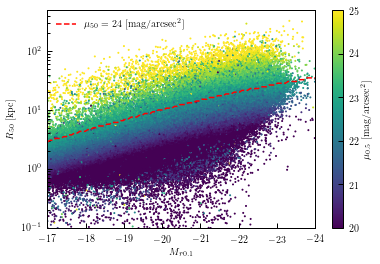

In [5]:
plt.figure()
plt.scatter(t_1['ABSMAG_r0.1'],  r,
            marker='o', s=1, c=mu,
            vmax=25,vmin=20)
l1, = plt.plot(M_sample, r_max, '--', color='red')
plt.xlim([-17,-24])
plt.ylim([0.1,500])
plt.yscale('log')
plt.colorbar(label=r'$\mu_{0.5}~[{\rm mag}/{\rm arcsec}^2]$')
plt.xlabel(r'$M_{r0.1}$')
plt.ylabel(r'$R_{50}~[{\rm kpc}]$')
plt.legend([l1,],[r'$\mu_{50}=24~[{\rm mag}/{\rm arcsec}^2]$',],
           loc='upper left', frameon=False)
plt.show()

(0.6377284491812947, 0.0, 20.879829441829052)
(0.6193270644990281, 0.0, 14.334825130169879)
(0.564859995466272, 0.0, 9.78528179221163)
(0.5092261479405779, 0.0, 7.055242137442548)
(0.47607322146799264, 0.0, 5.306581514654184)
(0.4780948513104976, 0.0, 4.177486981553215)
(0.5132373863615193, 0.0, 3.3853361128133663)
(0.5456064396337827, 0.0, 2.8601364784124073)
(0.5748719149921728, 0.0, 2.5331577980730673)
(0.5800654210771173, 0.0, 2.294663858300773)
(0.6314886581754412, 0.0, 2.089127052472013)
(0.6494948754583008, 0.0, 1.8962167535556822)
(0.6937570532098822, 0.0, 1.7206792462255136)
(0.6650376540160401, 0.0, 1.5075217318551057)
(0.8150639140978658, 0.0, 1.254432416394635)
(0.8846158449314196, 0.0, 1.0406522933540354)


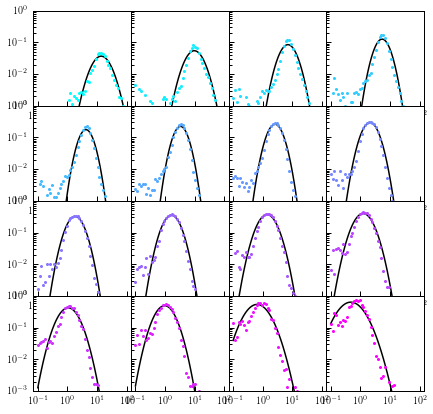

In [6]:
mag_bins = np.linspace(-23,-16,17)
r_bins = np.logspace(-1.0,2.0,50)

m = t_1['ABSMAG_r0.1']

# row and column sharing
fig, axes = plt.subplots(4, 4, sharey=True, figsize=(7.0,7.0))
axes = axes.flatten()
plt.subplots_adjust(wspace=0, hspace=0)

colors = plt.cm.cool(np.linspace(0,1,16))

from scipy.stats import lognorm

r_sample=np.logspace(-1,2,100)
for i in range(0,len(axes)):
    mask = (mag_bins[i] < m) & (mag_bins[i+1] > m) & (np.isfinite(r)) & (r>0.0)
    counts = np.histogram(r[mask], r_bins)[0]
    counts = 1.0*counts/np.sum(mask)/np.diff(r_bins)
    
    result = lognorm.fit(r[mask], floc=0.0)
    print(result)
    
    axes[i].plot(r_sample, lognorm.pdf(r_sample, loc=0, scale=result[2], s=result[0]),
                color='black')
    axes[i].plot(r_bins[:-1], counts, 'o', color=colors[i], ms=2)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xticks([0.1,1.0,10.0,100.0])
    axes[i].set_ylim([0.001,1])

In [7]:
from scipy import stats

disks = t_1['FRACPSF'][:,2] < 0.5
ellipticals = t_1['FRACPSF'][:,2] >= 0.5

mag_bins = np.arange(-24,-17,0.1)
mag_bin_centers = (mag_bins[:-1]+mag_bins[1:])/2.0
    
mask = (~np.isnan(t_1['ABSMAG_r0.1'])) & (r>0) & (r<100) & disks & (mu<24)
result_disks = stats.binned_statistic(t_1['ABSMAG_r0.1'][mask],  r[mask], 'median', bins=mag_bins)[0]
err_disks = stats.binned_statistic(t_1['ABSMAG_r0.1'][mask],  np.log10(r[mask]), 'std', bins=mag_bins)[0]

mask = (~np.isnan(t_1['ABSMAG_r0.1'])) & (r>0) & (r<100) & ellipticals & (mu<24)
result_ellipticals = stats.binned_statistic(t_1['ABSMAG_r0.1'][mask],  r[mask], 'median', bins=mag_bins)[0]
err_ellipticals = stats.binned_statistic(t_1['ABSMAG_r0.1'][mask],  np.log10(r[mask]), 'std', bins=mag_bins)[0]

/Users/duncan/anaconda2/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


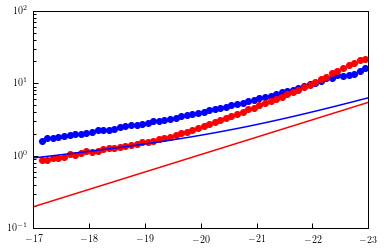

In [13]:
plt.figure()
plt.plot(mag_bin_centers, result_disks, 'o', color='blue')
#plt.plot(mag_bin_centers, result_disks-10**err_disks, '--', color='blue')
#plt.plot(mag_bin_centers, result_disks+10**err_disks, '--', color='blue')
plt.plot(mag_bin_centers, result_ellipticals, 'o', color='red')
#plt.plot(mag_bin_centers, result_ellipticals-10**err_ellipticals, '--', color='orange')
#plt.plot(mag_bin_centers, result_ellipticals+10**err_ellipticals, '--', color='orange')
plt.plot(m_sample, elliptical_sizes, color='red')
plt.plot(m_sample, disk_sizes, color='blue')
plt.xlim([-17,-23])
plt.ylim([0.1,100])
plt.yscale('log')
plt.show()

In [9]:
from galaxy_shapes.shape_models.size_model_components import Shen03EllipticalGalaxySizes, Shen03DiskGalaxySizes

elliptical_size_model = Shen03EllipticalGalaxySizes()
disk_size_model = Shen03DiskGalaxySizes()

In [10]:
m_sample = np.linspace(-23,-17,100)
elliptical_sizes = elliptical_size_model.median_size_model(m_sample)
disk_sizes = disk_size_model.median_size_model(m_sample)

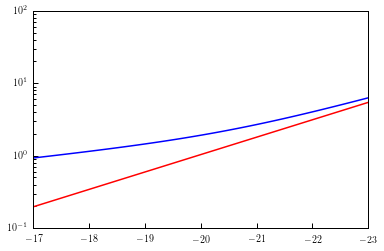

In [11]:
plt.figure()
plt.plot(m_sample, elliptical_sizes, color='red')
plt.plot(m_sample, disk_sizes, color='blue')
plt.xlim([-17,-23])
plt.ylim([0.1,100])
plt.yscale('log')
plt.show()